# Introduction


As data is related to neighoring features, We also optimized the 1d-CNN for this reason.

## Loading Libraries

In [ ]:
!pip install -U bayesian-optimization

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'

# Loading Dataset

Need to change the filename for other dataset: P2, OFS, PFS, OFS, and PFS.

In [ ]:
filename = 'Dataset P2.xlsx'
df = pd.read_excel(filename, index_col=0)
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [ ]:
X = X.values[:, :, np.newaxis]  # Reshape for 1D-CNN input

In [ ]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

for train_index, test_index in stratified_split.split(X, Y):
    X_train, X_test =X[train_index], X[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

print('X_train: {}     Y_train: {} \n X_test: {}     Y_test:{} '.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

X_train: (143, 3406, 1)     Y_train: (143,) 
 X_test: (36, 3406, 1)     Y_test:(36,) 


In [ ]:
def create_model(filters, kernel_size, pool_size, dense_units, learning_rate):
    model = Sequential()
    # 1D Convolutional layer
    model.add(Conv1D(filters=int(filters), kernel_size=int(kernel_size), activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=int(pool_size)))
    model.add(Flatten())
    model.add(Dense(int(dense_units), activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
def train_model(filters, kernel_size, pool_size, dense_units, learning_rate):
    mse_list = []
    for train_index, test_index in stratified_split.split(X_train, Y_train):
        X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
        y_cv_train, y_cv_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model = create_model(filters, kernel_size, pool_size, dense_units, learning_rate)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_cv_train, y_cv_train, epochs=100, batch_size=32, validation_split=0.2,
                  callbacks=[early_stopping], verbose=0)

        y_pred_test = model.predict(X_cv_test).flatten()
        mse = mean_squared_error(y_cv_test, y_pred_test)
        mse_list.append(mse)

    return -np.mean(mse_list)  # We minimize MSE, so negate it for optimization

In [ ]:
# Define parameter bounds
pbounds = {'filters': (16, 128),
           'kernel_size': (2, 10),
           'pool_size': (2, 5),
           'dense_units': (32, 256),
           'learning_rate': (0.001, 0.01)}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=train_model, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters
best_params = optimizer.max['params']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

|   iter    |  target   | dense_... |  filters  | kernel... | learni... | pool_size |
-------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
| 1         | -0.002718 | 115.9     | 122.5     | 7.856     | 0.006388  | 2.468     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
| 2         | -0.002828 | 66.94     | 22.51     | 8.929     | 0.00641   | 4.124     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
| 3         | -0.01718  | 36.61     | 124.6     | 8.66      | 0.002911  | 2.545     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
| 4         | -0.002067 | 73.08     | 50.08     | 6.198     | 0.004888  | 2.874     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
| 5         | -0.005507 | 169.1     | 31.62     | 4.337     | 0.004297  | 3.368     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
| 6         | -0.003436 | 120.6     | 70.45     | 9.52      | 0.006917  | 2.871     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
| 7         | -0.002402 | 71.89     | 49.39     | 5.427     | 0.001908  | 2.816     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
| 8         | -0.002792 | 111.5     | 16.48     | 9.526     | 0.007395  | 4.874     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
| 9         | -0.003749 | 176.4     | 127.8     | 6.232     | 0.001104  | 3.606     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
| 10        | -0.005602 | 255.9     | 127.8     | 4.865     | 0.003066  | 3.758     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
| 11        | -0.004188 | 254.3     | 18.22     | 8.405     | 0.006588  | 3.134     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
| 12        | -0.005917 | 222.9     | 74.16     | 9.995     | 0.008156  | 4.66      |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
| 13        | -0.0028   | 97.86     | 44.33     | 3.846     | 0.001519  | 4.472     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
| 14        | -0.007075 | 88.11     | 82.46     | 7.84      | 0.002894  | 4.907     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
| 15        | -0.005063 | 146.6     | 101.4     | 2.962     | 0.003327  | 2.322     |
Best Hyperparameters:
{'dense_units': np.float64(73.08261020716918), 'filters': np.float64(50.075131211468225), 'kernel_size': np.float64(6.198051453057903), 'learning_rate': np.float64(0.004887505167779043), 'pool_size': np.float64(2.8736874205941256)}


In [ ]:
# Train the model with the best hyperparameters
best_model = create_model(**best_params)
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the training set
y_pred_train = best_model.predict(X_train).flatten()

# Calculate metrics on the training set
mse_train = mean_squared_error(Y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, y_pred_train)
r2_train = 1 - mse_train / np.var(Y_train)

# Print the results for training set
print('Training Set: ')
print(f'Mean Squared Error: {mse_train}')
print(f'Root Mean Squared Error: {rmse_train}')
print(f'Mean Absolute Error: {mae_train}')
print(f'R-squared: {r2_train}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Training Set: 
Mean Squared Error: 0.003218922439911508
Root Mean Squared Error: 0.05673554829127421
Mean Absolute Error: 0.03974778426068646
R-squared: 0.9640158119293258


In [ ]:
# Train the model with the best hyperparameters
best_model = create_model(**best_params)
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the testing set
y_pred_test = best_model.predict(X_test).flatten()

# Calculate metrics on the testing set
mse_test = mean_squared_error(Y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, y_pred_test)
r2_test = 1 - mse_test / np.var(Y_test)

# Print the results for testing set
print('\nTesting Set: ')
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'R-squared: {r2_test}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Testing Set: 
Mean Squared Error: 0.003991566731642388
Root Mean Squared Error: 0.063178847185133
Mean Absolute Error: 0.046033205785271196
R-squared: 0.9585497789762301


In [ ]:
# Predict on the training set
y_pred_train = best_model.predict(X_train).flatten()

# Calculate residuals for training set
residuals_train = Y_train - y_pred_train

# Predict on the testing set
y_pred_test = best_model.predict(X_test).flatten()

# Calculate residuals for testing set
residuals_test = Y_test - y_pred_test

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


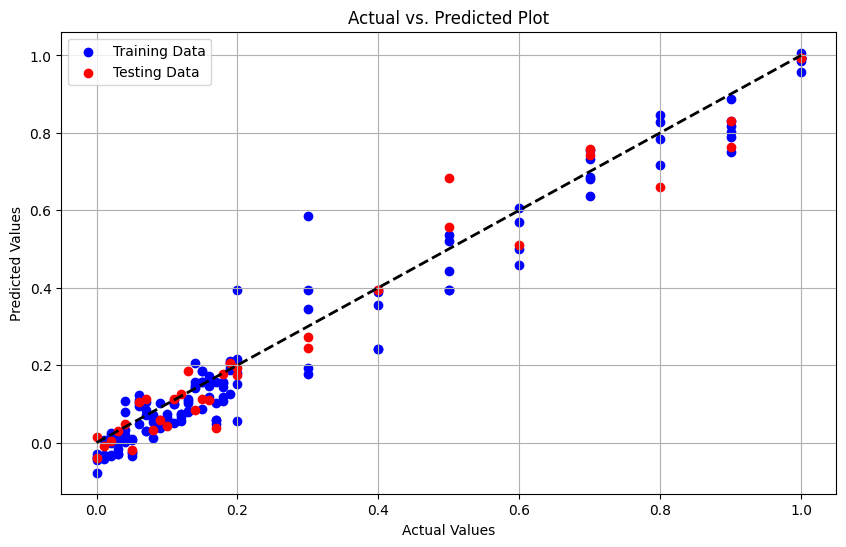

In [ ]:
# Plot actual vs. predicted plot for both training and testing sets
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(Y_train, y_pred_train, color='blue', label='Training Data')

# Plot testing data
plt.scatter(Y_test, y_pred_test, color='red', label='Testing Data')

# Plot diagonal line
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='black', lw=2, linestyle='--')

plt.title('Actual vs. Predicted Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Save the figure with 600 DPI as a JPEG image
plt.savefig('F17.jpg', dpi=600, format='jpg', bbox_inches='tight')

plt.show()

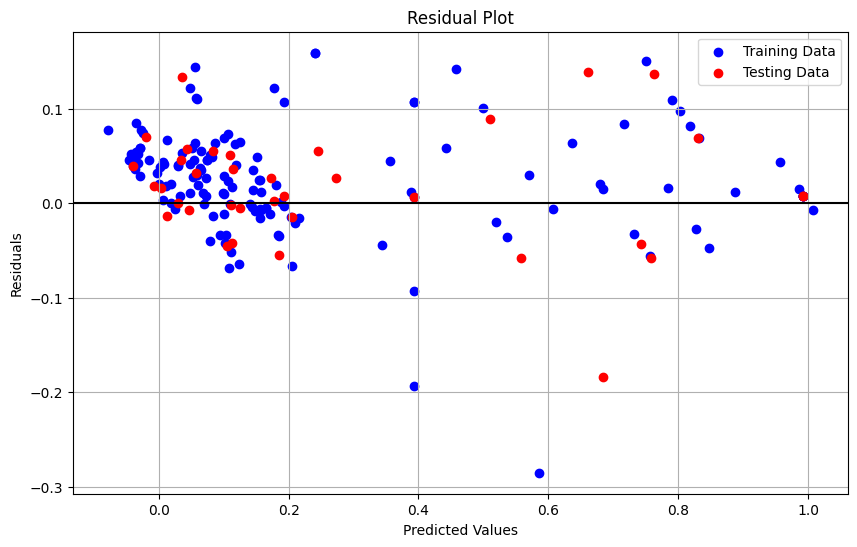

In [ ]:
# Plot residual plot for both training and testing sets
plt.figure(figsize=(10, 6))

# Plot training residuals
plt.scatter(y_pred_train, residuals_train, color='blue', label='Training Data')

# Plot testing residuals
plt.scatter(y_pred_test, residuals_test, color='red', label='Testing Data')

# Plot horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

# Save the figure with 600 DPI as a JPEG image
plt.savefig('F18.jpg', dpi=600, format='jpg', bbox_inches='tight')

plt.show()